## Train the baseline model using classification loss only 

In [15]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F

import matplotlib.pyplot as plt

import seaborn as sns
sns.set_theme(color_codes=True)
import os
import sys

import transformers
from transformers import AutoModelForImageClassification, AutoConfig, AutoFeatureExtractor
from transformers.utils import logging
from transformers import DefaultDataCollator

logging.set_verbosity(transformers.logging.ERROR) 
logging.disable_progress_bar() 

p = os.path.abspath('../')
sys.path.insert(1, p)

from src.utils.utils import *
from src.wordnet_ontology.wordnet_ontology import WordnetOntology

from torch.utils.data import DataLoader 
from functools import partial 
from torchtext.vocab import build_vocab_from_iterator

from torchtext.data.utils import get_tokenizer
from torch.utils.data import Dataset

from torch.utils.data import DataLoader, Dataset

from torchvision.io import read_image
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor
import evaluate
from transformers import TrainingArguments, Trainer
import math
import copy

from collections import defaultdict

import random
import torchvision
import torchvision.transforms as transforms

from datasets import Image
from datasets import load_dataset
import wn 

seed=7361
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

n_excluded_classes = int(556 * 0.05)

%load_ext autoreload
%autoreload 2

wn_en = wn.Wordnet('omw-en')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
mapping_filename = './data/external/imagenet/LOC_synset_mapping.txt'
wn = WordnetOntology(mapping_filename)

vocab = torch.load('./models/vocab.pt')

sketch = load_dataset("imagenet_sketch", split='train', cache_dir='./cache/')

Found cached dataset imagenet_sketch (/mnt/HDD/kevinds/sketch/./cache/imagenet_sketch/default/0.0.0/9bbda26372327ae1daa792112c8bbd2545a91b9f397ea6f285576add0a70ab6e)


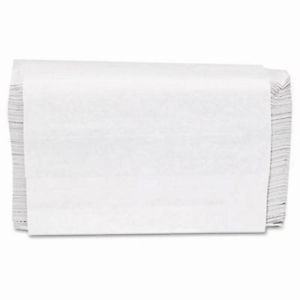

In [17]:
sketch[0]['image']

In [18]:
def get_hclass(x):
    _class = wn.class_for_index[x['label']] 
    return { 
        'label': vocab[wn.hypernym(_class)] 
    }

sketch = sketch.map(get_hclass)

Loading cached processed dataset at /mnt/HDD/kevinds/sketch/./cache/imagenet_sketch/default/0.0.0/9bbda26372327ae1daa792112c8bbd2545a91b9f397ea6f285576add0a70ab6e/cache-4bdc4125347390de.arrow


In [19]:
_classes = list(set(sketch['label']))
excluded_classes = [random.choice(_classes) for i in range(n_excluded_classes)]
dt = train_test_split(sketch, excluded_labels=excluded_classes)
train, test = dt['train'], dt['test']

In [20]:
[vocab.get_itos()[_cl] for _cl in excluded_classes]

['n02085374',
 'n04490091',
 'n01632047',
 'n12056217',
 'n02329401',
 'n04015204',
 'n04100174',
 'n02087122',
 'n02453611',
 'n02796623',
 'n03211117',
 'n03706653',
 'n04202417',
 'n02887209',
 'n04549122',
 'n01703569',
 'n04586421',
 'n12157056',
 'n03953416',
 'n04520170',
 'n01816887',
 'n02534734',
 'n04187061',
 'n06595351',
 'n04151581',
 'n02268148',
 'n15074962']

In [21]:
feature_extractor = AutoFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")

_transforms = transforms.Compose([
    transforms.PILToTensor(),
    transforms.Resize((feature_extractor.size, feature_extractor.size)),
    transforms.ConvertImageDtype(torch.float),
    Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std),
])

def get_pixel_values(examples):
    images = [ _transforms(image.convert("RGB")) for image in examples['image']]
    examples["pixel_values"] = images
    del examples["image"]
    return examples

train = train.with_transform(get_pixel_values)
test = test.with_transform(get_pixel_values)
collator = DefaultDataCollator()

In [22]:
torch.hub.set_dir('../cache')
model = AutoModelForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k", 
    num_labels=len(vocab),
    label2id=vocab.get_stoi(),
    id2label={i:l for i, l in enumerate(vocab.get_itos())}
)
feature_extractor = AutoFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")
data_collator = DefaultDataCollator()

cb = StoreLosses()

In [24]:
accuracyk = evaluate.load("KevinSpaghetti/accuracyk")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    
    k=5
    top1_pred = np.argmax(logits, axis=-1, keepdims=True)
    top5_pred = np.argpartition(logits, -k, axis=-1)[:, -k:]
    
    top1 = accuracyk.compute(predictions=top1_pred, references=labels)
    top5 = accuracyk.compute(predictions=top5_pred, references=labels)
    return {
        'top1': top1['accuracy'],
        'top5': top5['accuracy']
    }

training_args = TrainingArguments(
    output_dir="./models/baseline",
    num_train_epochs=16,
    learning_rate=2e-4,
    per_device_train_batch_size=36,
    per_device_eval_batch_size=36,
    gradient_accumulation_steps=8,
    warmup_steps=100,
    weight_decay=0.01,
    remove_unused_columns=False,
    evaluation_strategy='steps',
    eval_steps=200,
    report_to="none",
    dataloader_num_workers=4,
    dataloader_pin_memory=True,
    fp16=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train,
    eval_dataset=test,
    compute_metrics=compute_metrics,
    tokenizer=feature_extractor
)

trainer.train()

PyTorch: setting up devices
Using cuda_amp half precision backend
/home/kevinds/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 37863
  Num Epochs = 16
  Instantaneous batch size per device = 36
  Total train batch size (w. parallel, distributed & accumulation) = 288
  Gradient Accumulation steps = 8
  Total optimization steps = 2096
  Number of trainable parameters = 86226220


OutOfMemoryError: CUDA out of memory. Tried to allocate 64.00 MiB (GPU 0; 23.69 GiB total capacity; 3.96 GiB already allocated; 80.38 MiB free; 4.11 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF